In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# the folder download from nma, containing subjects/, regions.npy, subjects_list.txt
HCP_DIR = "hcp_task/"

# name of your task
task = "SOCIAL"
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [3]:
# do not have to change this cell

RUNS = ['LR','RL']
N_SUBJECTS = 100
N_PARCELS = 360
TR = 0.72
N_RUNS = 2

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}

In [4]:
# do not have to change this cell
# functions copied from nma

def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [5]:
# for 1 sub
sub = subjects[0]
print(sub)

100307


In [6]:
for i_run in range(2):
    
    run = RUNS[i_run]
    dir_data = os.path.join(HCP_DIR, 'subjects', sub, task, 'tfMRI_'+task+'_'+run, 'data.npy')
    data = np.load(dir_data)
    
    evs = load_evs(subject=sub, experiment=task, run=i_run)
    evs = [[arr - 1 for arr in sublist] for sublist in evs]
    # do not have to change the code above
    
    ts_cond1_run = np.concatenate([data[:, evs[0][i]] for i in range(len(evs[0]))], axis=1)
    ts_cond2_run = np.concatenate([data[:, evs[1][i]] for i in range(len(evs[1]))], axis=1)
    # if you have condition 5, notice the part range(len(evs[4])), where 4 = 5-1
    # ts_cond5_run = np.concatenate([data[:, evs[4][i]] for i in range(len(evs[4]))], axis=1)    
    
    if i_run == 0:
        ts_cond1 = ts_cond1_run
        ts_cond2 = ts_cond2_run
        #ts_cond5 = ts_cond5_run
    else:
        ts_cond1 = np.concatenate([ts_cond1, ts_cond1_run], axis=1)
        ts_cond2 = np.concatenate([ts_cond2, ts_cond2_run], axis=1)
        #ts_cond5 = np.concatenate([ts_cond5, ts_cond5_run], axis=1)
        
fc_con1 = np.corrcoef(ts_cond1)
fc_con2 = np.corrcoef(ts_cond2)
#fc_con5 = np.corrcoef(ts_cond5)

print(ts_cond1.shape)
print(ts_cond2.shape)

print(fc_con1.shape)
print(fc_con2.shape)

(360, 128)
(360, 192)
(360, 360)
(360, 360)


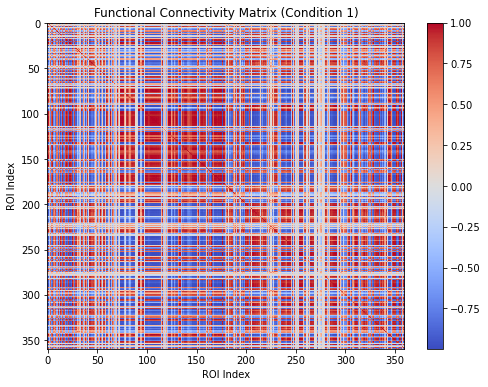

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(fc_con1, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Functional Connectivity Matrix (Condition 1)')
plt.xlabel('ROI Index')
plt.ylabel('ROI Index')
plt.show()

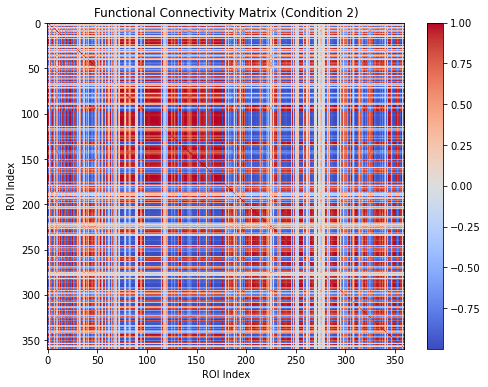

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(fc_con2, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Functional Connectivity Matrix (Condition 2)')
plt.xlabel('ROI Index')
plt.ylabel('ROI Index')
plt.show()